In [2]:
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('../../data/model1_cv_role/3.processed/v1_english/cv_labeled_final.csv')


In [4]:
# Nos quedamos solo con lo que necesitamos
X = df["cv_text"]
y = df["role_label_final"]

print(df.shape)
df.head()

(8264, 6)


,cv_id,cv_text,role_label_final,role_raw,source_dataset,resume_len
0,1,Python Developer Python Developer Python Devel...,python_developer,Python_Developer,dataset1_avishek,3467
1,2,R&D Engineer R&D Engineer R&D Engineer - Nokia...,python_developer,Python_Developer,dataset1_avishek,2812
2,3,Sr. Full Stack Developer Sr. Full Stack Develo...,python_developer,Python_Developer,dataset1_avishek,16606
3,4,Sr. Full Stack Python Developer Sr. Full Stack...,python_developer,Python_Developer,dataset1_avishek,9253
4,5,Sr. Python Developer Sr. Python Developer Sr. ...,python_developer,Python_Developer,dataset1_avishek,15659


In [5]:
# Primero: train (70%) y temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Después: valid (15%) y test (15%) a partir del 30% restante
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,   # la mitad de ese 30% -> 15%
    stratify=y_temp,
    random_state=42
)

len(X_train), len(X_valid), len(X_test)


(5784, 1240, 1240)

In [6]:
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.9,
        sublinear_tf=True
    )),
    ("clf", LinearSVC(
        class_weight="balanced",
        random_state=42
    ))
])


In [7]:
pipeline.fit(X_train, y_train)

y_valid_pred = pipeline.predict(X_valid)

print(classification_report(y_valid, y_valid_pred))


                        precision    recall  f1-score   support

     backend_developer       1.00      1.00      1.00         3
        cloud_engineer       1.00      1.00      1.00         4
        data_scientist       1.00      1.00      1.00         5
database_administrator       0.98      0.98      0.98       137
    frontend_developer       0.80      0.82      0.81        82
   fullstack_developer       1.00      1.00      1.00         4
        java_developer       0.98      0.99      0.98       179
           ml_engineer       1.00      1.00      1.00         2
  mobile_app_developer       1.00      1.00      1.00         4
 network_administrator       0.90      0.82      0.86        68
       project_manager       0.97      0.99      0.98       108
      python_developer       0.99      0.98      0.99       194
      security_analyst       0.99      0.97      0.98       130
    software_developer       0.82      0.65      0.72        62
 systems_administrator       0.88      

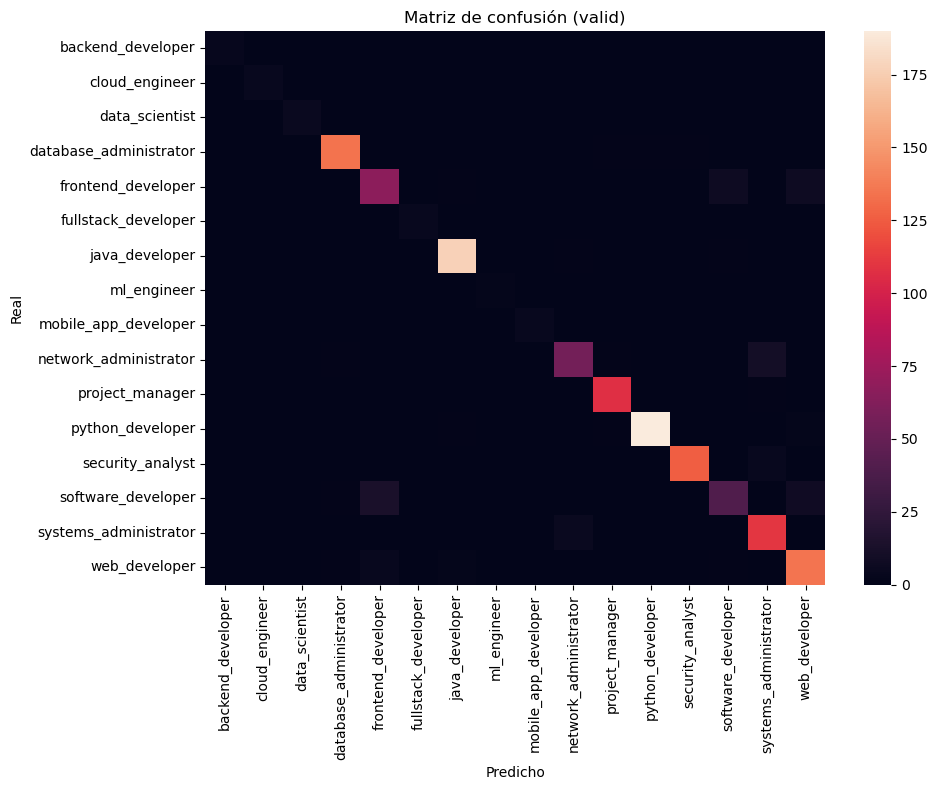

In [8]:
import numpy as np

labels = sorted(y.unique())

cm = confusion_matrix(y_valid, y_valid_pred, labels=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de confusión (valid)")
plt.tight_layout()
plt.show()


In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [3, 5],
    "tfidf__max_df": [0.85, 0.9],
    "clf__C": [0.5, 1.0, 2.0]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring="f1_macro",
    verbose=2
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor F1 macro en CV:", grid.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores parámetros: {'clf__C': 2.0, 'tfidf__max_df': 0.85, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
Mejor F1 macro en CV: 0.9370853441435956


In [10]:
best_model = grid.best_estimator_
y_valid_pred_best = best_model.predict(X_valid)
print(classification_report(y_valid, y_valid_pred_best))


                        precision    recall  f1-score   support

     backend_developer       1.00      1.00      1.00         3
        cloud_engineer       1.00      1.00      1.00         4
        data_scientist       1.00      1.00      1.00         5
database_administrator       0.97      0.98      0.97       137
    frontend_developer       0.81      0.82      0.81        82
   fullstack_developer       1.00      1.00      1.00         4
        java_developer       0.98      0.99      0.99       179
           ml_engineer       1.00      1.00      1.00         2
  mobile_app_developer       1.00      1.00      1.00         4
 network_administrator       0.87      0.81      0.84        68
       project_manager       0.97      0.99      0.98       108
      python_developer       0.99      0.99      0.99       194
      security_analyst       0.98      0.97      0.98       130
    software_developer       0.84      0.66      0.74        62
 systems_administrator       0.88      

In [11]:
# Unimos train + valid
X_train_full = pd.concat([X_train, X_valid])
y_train_full = pd.concat([y_train, y_valid])

final_model = grid.best_estimator_  # o pipeline si no usaste grid

final_model.fit(X_train_full, y_train_full)

y_test_pred = final_model.predict(X_test)
print(classification_report(y_test, y_test_pred))


                        precision    recall  f1-score   support

     backend_developer       1.00      1.00      1.00         3
        cloud_engineer       1.00      1.00      1.00         3
        data_scientist       1.00      1.00      1.00         4
database_administrator       0.96      0.98      0.97       138
    frontend_developer       0.79      0.74      0.77        82
   fullstack_developer       1.00      1.00      1.00         5
        java_developer       0.99      0.99      0.99       179
           ml_engineer       1.00      1.00      1.00         3
  mobile_app_developer       1.00      1.00      1.00         3
 network_administrator       0.87      0.76      0.81        68
       project_manager       0.95      0.98      0.97       108
      python_developer       0.98      0.99      0.99       194
      security_analyst       0.98      0.97      0.98       130
    software_developer       0.79      0.73      0.76        62
 systems_administrator       0.88      